# Working with AER

Address-event representations (AER) is one of many ways to represent events. In AER, a single event is represented by a tuple, describing its "coordinates" in spacetime. For a 2-dimensional camera, that can be

$$
t \times x \times y
$$

If we have many events (and we do!), then we observe a very long list of these AER tuples, like this in `csv` format:

```csv
0,120,3
0,271,128
...
```

Note that this is very different from how we are normally working with data (in dense tensors). So, first, we should convert these coordinates to tensors.

## Task 0: Imports

In [6]:
import numpy as np
import torch
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
import tqdm

## Task 1: Working with coordinates

We prepared a simple sample in a CSV file. It's in the file `sample.csv`. Load it using `numpy.loadtxt` or similar. Can you make sense of it? What does it show? Can you name each column?

In [2]:
filename, _ = urlretrieve("https://raw.githubusercontent.com/ncskth/phd-course/main/book/module3/sample.csv")
data = np.loadtxt(filename, delimiter=",")
# ...

## Task 2: Working with event files

The CSV format is poorly suited for describing AER data. For that, we have more sophisticated AER representations, such as [AEDAT](https://gitlab.com/inivation/inivation-docs/blob/master/Software%20user%20guides/AEDAT_file_formats.md#aedat-40), [EVT](https://docs.prophesee.ai/stable/data/encoding_formats/evt3.html), [RAW](https://docs.prophesee.ai/stable/data/file_formats/raw.html), and several others. Fortunately, we have a piece of software that can help us out: [AEStream](https://github.com/aestream/aestream)

Before getting started, install AEStream below:

In [3]:
!pip install aestream -q

## Task 2.1: Loading up all the events

Import it and use the `FileInput` to `.load()` another sample, this time using the EVT format in a file named `sample.dat`. Can you figure out what aestream loaded for us?

In [4]:
import aestream
filename_dat, _ = urlretrieve("https://raw.githubusercontent.com/ncskth/phd-course/main/book/module3/sample.dat", filename="sample.dat")
events = aestream.FileInput(filename_dat, (640, 480)).load()
# ...

**Hint**: Note that the events are now four dimensions. Why do you think that is?

## Task 2.2: Working with frames

The problem with the AER format is that it's pretty unhandy when we work with neural networks on CPUs and GPUs.
Here, we will need tensors of a fixed shape that we can pass into our networks.

The code below creates frames for you in a very manual and tedious way. 

* Can you tell what the code is doing?
* Why is it slow? And what could you do to make it faster?

In [15]:
# We only look at the first 10^6 events
events_subset = events[:1000000] 
# The interval between frames
time_interval = 1000

# Start generating a number of frames
frames = []
index = 0
current_frame = torch.zeros(2, 640, 480)
for (t, x, y, p) in tqdm.tqdm(events_subset):
    if t // time_interval > index:
        frames.append(current_frame.clone())
        current_frame.fill_(0)
        index += 1
    current_frame[p, x, y] = 1

100%|██████████████████████████████████████████████████████████| 539481/539481 [00:08<00:00, 65227.16it/s]


### Task 2.3: Plot the frames

Let's inspect the frames that came out of this. Is it reasonable to use this as input data to the task below: a convolutional edge detector? Why/why not?

In [23]:
# plt.imshow(...)

### 2.4: Rework the `time_interval` above to produce more reasonable frames

**Spoiler**: the frames above are weird.
Probably because the `time_interval` setting above is wrong.

Fix it! Then re-run your frames and inspect them to see if they make more sense.

## Task 3: Convolutional edge detector

In this task, we'll create a convolutional edge detector.
It will work very similar to a regular convolutional neural network in the sense that we "simply" take a kernel that looks for an elementary (edge) pattern and then apply it to the incoming frames.
Easy.
And it works well with events, too.


Here's a video that shows you a an example from the [AEStream docs](https://github.com/aestream/aestream/blob/main/example/usb_edgedetection.py) where we detect horizontal and vertical edges.
Use the code for inspiration.

![](https://media.githubusercontent.com/media/aestream/aestream/main/example/usb_edgedetection.gif)

### Task 3.1 Define a kernel

The first step is to define a kernel that can detect a certain type of edge. Here's one example you can use if you'd like. Can you figure out what this code is doing?

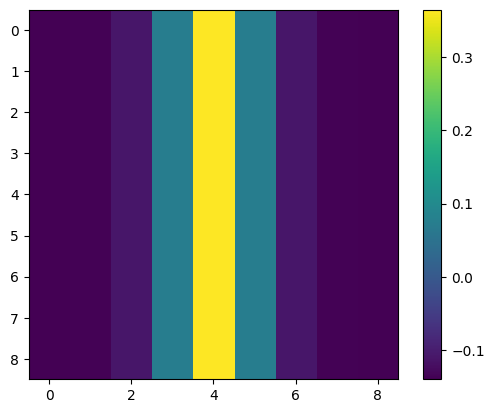

In [9]:
kernel_size = 9
gaussian = torch.sigmoid(torch.linspace(-10, 10, kernel_size + 1))
kernel = (gaussian.diff() - 0.14).repeat(kernel_size, 1)
plt.imshow(kernel)
plt.colorbar()

### Task 3.2

Use your kernel in a convolutional layer.

In [10]:
net = ...

### Task 3.3

Apply your convolutional network to the frames above. Do you see what you expect?

Try tweaking your kernels above to see if you can get more meaningful results.

In [25]:
# output = []
# for frame in frames:
#   output.append(net(frame))
#    ...